In [1]:
# Dependencies and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import time
from pandas import ExcelWriter
from pandas import ExcelFile
from pprint import pprint
from scipy.stats import linregress
from datetime import timedelta

In [2]:
fileordprod = "./data/brazilian-ecommerce/olist_order_items_dataset.csv"
fileordcusttime = "./data/brazilian-ecommerce/olist_orders_dataset.csv"
fileprodcat = "./data/brazilian-ecommerce/olist_products_dataset.csv"
fileprodtransl = "./data/brazilian-ecommerce/product_category_name_translation.csv"

# Read Purchasing File and store into Pandas data frame
ordprod = pd.read_csv(fileordprod)[['order_id', 'product_id', 'price']]
ordcusttime= pd.read_csv(fileordcusttime)[['order_id', 'customer_id', 'order_purchase_timestamp']]
prodcat = pd.read_csv(fileprodcat)[['product_id', 'product_category_name']]
prodtransl = pd.read_csv(fileprodtransl)

mergedf = pd.merge(ordcusttime, ordprod, on = 'order_id',how= 'left')
mergedf = pd.merge(mergedf, prodcat, on = 'product_id', how = 'left')
mergedf = pd.merge(mergedf, prodtransl, on = 'product_category_name', how = 'left')
renamecolumns = {
    'order_purchase_timestamp': 'order_time',
    'product_category_name_english': 'category'
}
mergedf = mergedf.rename(columns = renamecolumns)


#minus one day
mergedf ["date_time"]= pd.to_datetime(mergedf['order_time']) - timedelta(days=1)



#converted to MM/YY Format
mergedf['YYYY'] = pd.DatetimeIndex(mergedf['date_time']).year
mergedf['MM'] = pd.DatetimeIndex(mergedf['date_time']).month

mergedf['month'] = pd.to_datetime(mergedf['date_time'])
mergedf['day'] = mergedf['month'].dt.strftime('%m/%d/%y')
mergedf['month'] = mergedf['month'].dt.strftime('%m/%y')

mergedf.head()

,order_id,customer_id,order_time,product_id,price,product_category_name,category,date_time,YYYY,MM,month,day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,29.99,utilidades_domesticas,housewares,2017-10-01 10:56:33,2017,10,10/17,10/01/17
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,595fac2a385ac33a80bd5114aec74eb8,118.70,perfumaria,perfumery,2018-07-23 20:41:37,2018,7,07/18,07/23/18
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,aa4383b373c6aca5d8797843e5594415,159.90,automotivo,auto,2018-08-07 08:38:49,2018,8,08/18,08/07/18
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,pet_shop,pet_shop,2017-11-17 19:28:06,2017,11,11/17,11/17/17
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,65266b2da20d04dbe00c5c2d3bb7859e,19.90,papelaria,stationery,2018-02-12 21:18:39,2018,2,02/18,02/12/18


In [3]:
urlBOV = "https://www.quandl.com/api/v3/datasets/BCB/7.json?api_key=2vRuu5GNchksqBdcAHzc"
responseBOV = requests.get(urlBOV).json()


In [4]:
days = 10

BOV_df = pd.DataFrame(responseBOV['dataset']['data'])

BOV_df = BOV_df.rename(index=str, columns={0: "day", 1: "BOV"})

BOV_df['day'] = pd.to_datetime(BOV_df['day'])
BOV_df['day'] = BOV_df['day'].dt.strftime('%m/%d/%y')
BOV_df['BOV'] = pd.to_numeric(BOV_df['BOV'])
BOV_df = BOV_df.sort_values(by = 'day', ascending = True)
BOV_df['BOVdiff'] = BOV_df['BOV'].diff(periods = days)
BOV_df['BOVma'] = BOV_df['BOV'].rolling(window = days).mean()
BOV_df.head(20)

metriclist = ['BOV', 'BOVdiff', 'BOVma']
mergedf = pd.merge(mergedf, BOV_df, on = 'day', how = 'left')

In [5]:
# mergedf['day'] = pd.to_datetime(mergedf['day']) - 1


In [6]:
#mergedf['category'].unique()

In [7]:
# red = fashion/clothing
    # 'perfumery', 'watches_gifts','fashion_underwear_beach','fashion_bags_accessories','fashion_shoes','fashion_male_clothing','fashion_sport','fashio_female_clothing','fashion_childrens_clothes'
# orange = home/furniture
    # 'housewares','furniture_decor','office_furniture','bed_bath_table','home_confort','furniture_bedroom','kitchen_dining_laundry_garden_furniture','home_comfort_2','furniture_mattress_and_upholstery'
# yellow = construction/tools
    # 'garden_tools','construction_tools_construction','construction_tools_lights','construction_tools_garden','construction_tools_safety','home_construction','construction_tools_tools'
# purple = electronics
    # 'computers_accessories','telephony','electionics','cds_dvds_musicals','consoles_games','audio','tablets_printing_image','computers','dvds_blu_ray','music'
# green = food and drink
    # 'food','drinks','food_drink','la_cuisine'
# cyan = books
    # 'books_general_interest','books_imported','books_technical'
# gray = appliances
    # 'air_conditioning','small_appliances','home_appliances','home_appliances_2','small_appliances_home_oven_and_coffee'

In [40]:
new_categories = {'fashion_clothing': ['perfumery', 'luggage_accessories','watches_gifts','fashion_underwear_beach','fashion_bags_accessories','fashion_shoes','fashion_male_clothing','fashion_sport','fashio_female_clothing','fashion_childrens_clothes'],
                  'home_furniture': ['housewares','art','arts_and_craftmanship','furniture_decor','office_furniture','bed_bath_table','home_confort','furniture_bedroom','kitchen_dining_laundry_garden_furniture','home_comfort_2','furniture_mattress_and_upholstery'],
                  'construction_tools': ['garden_tools','construction_tools_construction','construction_tools_lights','construction_tools_garden','construction_tools_safety','home_construction','construction_tools_tools'],
                  'electronics': ['computers_accessories','telephony','electionics','cds_dvds_musicals','consoles_games','audio','tablets_printing_image','computers','dvds_blu_ray','music'],
                  'food_drink': ['food','drinks','food_drink','la_cuisine'],
                  'books': ['books_general_interest','books_imported','books_technical'],
                  'appliances': ['air_conditioning','small_appliances','home_appliances','home_appliances_2','small_appliances_home_oven_and_coffee'],
                    'auto': ['auto'],
                    'industry':['agro_industry_and_commerce','industry_commerce_and_business'],
                    'other':['pet_shop','stationary','toys','baby','cool_stuff','sports_leisure','diapers_and_hygeine','signaling_and_security','party_supplies','cine_photo','market_place','musical_instruments','christmas_supplies']}
                    
new_dict = {}
for key,valuelist in new_categories.items():
    for v in valuelist:
        new_dict[v] = key
print(new_dict)


{'perfumery': 'fashion_clothing', 'luggage_accessories': 'fashion_clothing', 'watches_gifts': 'fashion_clothing', 'fashion_underwear_beach': 'fashion_clothing', 'fashion_bags_accessories': 'fashion_clothing', 'fashion_shoes': 'fashion_clothing', 'fashion_male_clothing': 'fashion_clothing', 'fashion_sport': 'fashion_clothing', 'fashio_female_clothing': 'fashion_clothing', 'fashion_childrens_clothes': 'fashion_clothing', 'housewares': 'home_furniture', 'art': 'home_furniture', 'arts_and_craftmanship': 'home_furniture', 'furniture_decor': 'home_furniture', 'office_furniture': 'home_furniture', 'bed_bath_table': 'home_furniture', 'home_confort': 'home_furniture', 'furniture_bedroom': 'home_furniture', 'kitchen_dining_laundry_garden_furniture': 'home_furniture', 'home_comfort_2': 'home_furniture', 'furniture_mattress_and_upholstery': 'home_furniture', 'garden_tools': 'construction_tools', 'construction_tools_construction': 'construction_tools', 'construction_tools_lights': 'construction_too

In [41]:
mergedf['category'] = mergedf.category.replace(new_dict)

In [42]:
#Rid of black friday
mergedf = mergedf.loc[mergedf['day'] != '11/24/17']

In [28]:
#commented out because it lags when rerunning all 

#save to excel file 

# writer = ExcelWriter('output.xlsx')
# mergedf.to_excel(writer,'Sheet1',index=False)
# writer.save()

In [29]:
home_furniture = mergedf['price'][mergedf['category']=='home_furniture'].sum()
fashion_clothing = mergedf['price'][mergedf['category']=='fashion_clothing'].sum()
construction_tools = mergedf['price'][mergedf['category']=='construction_tools'].sum()
electronics = mergedf['price'][mergedf['category']=='electronics'].sum()
food_drink = mergedf['price'][mergedf['category']=='food_drink'].sum()
books = mergedf['price'][mergedf['category']=='books'].sum()
appliances = mergedf['price'][mergedf['category']=='appliances'].sum()
#data['duration'][data['item'] == 'call'].sum()

total_spend = home_furniture + fashion_clothing + construction_tools + electronics + food_drink + books + appliances

category_spend = {home_furniture:'home_furniture',
                        fashion_clothing:'fashion_clothing',
                        construction_tools:'construction_tools',
                        electronics:'electronics',
                        food_drink:'food_drink',
                        books:'books',
                        appliances:'appliances'
                       }

In [30]:
mergedf['category'].nunique()

33

In [31]:
print(category_spend)

{2787998.3400000003: 'home_furniture', 1799385.9300000002: 'fashion_clothing', 789713.5900000001: 'construction_tools', 1838155.98: 'electronics', 69011.58: 'food_drink', 70172.79: 'books', 485325.04000000004: 'appliances'}


In [32]:
print(total_spend)

7839763.25


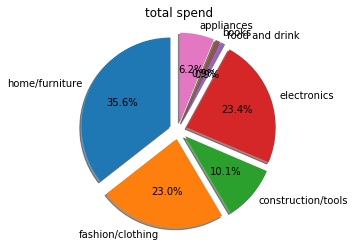

In [33]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'home/furniture', 'fashion/clothing', 'construction/tools', 'electronics','food and drink','books','appliances'
sizes = [home_furniture, fashion_clothing, construction_tools, electronics, food_drink, books, appliances]
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('total spend')
plt.show()

In [34]:
#Black Friday!
mergedf.loc[mergedf['day'] == '11/24/17']

,order_id,customer_id,order_time,product_id,price,product_category_name,category,date_time,YYYY,MM,month,day,BOV,BOVdiff,BOVma


In [35]:
groupdf = mergedf.groupby(['BOVdiff', 'category'])
groupdf = groupdf.sum()
groupdf.head()

price  YYYY  MM       BOV     BOVma
BOVdiff category                                             
35625.0 fashion_clothing   10.9  2016  12   57255.0   48428.7
38089.0 cool_stuff        798.0  4034   2  123330.0  100894.2
        fashion_clothing  149.0  2017   1   61665.0   50447.1
        health_beauty     370.0  2017   1   61665.0   50447.1
        home_furniture     34.9  2017   1   61665.0   50447.1

<class 'str'>
R2 = 0.21610448959051842


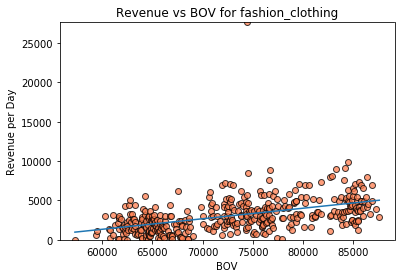

<class 'str'>
R2 = 0.2823423226770848


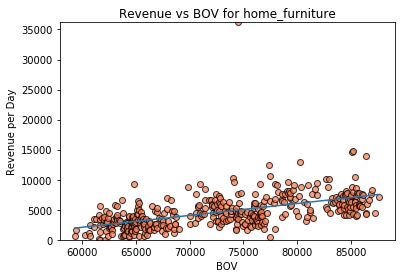

<class 'str'>
R2 = 0.23569539814695983


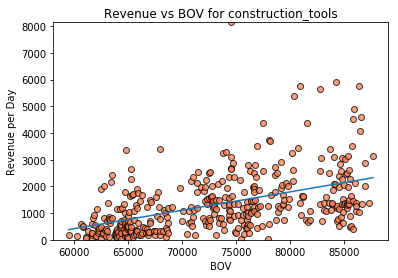

<class 'str'>
R2 = 0.20699498340199607


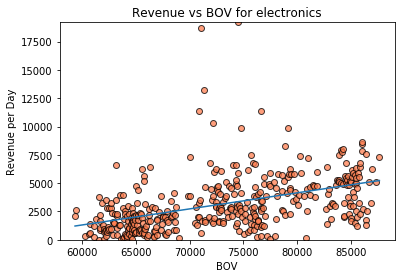

<class 'str'>
R2 = 0.05303943309916283


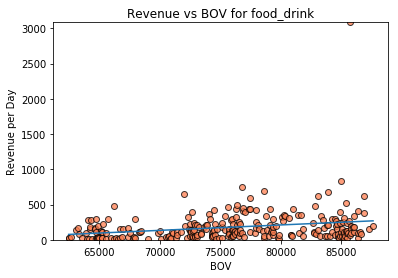

<class 'str'>
R2 = 0.028347083680704956


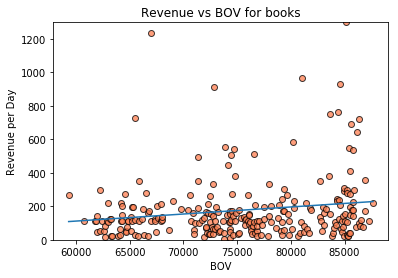

<class 'str'>
R2 = 0.0760253941806458


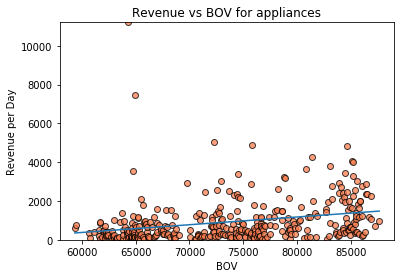

<class 'str'>
R2 = 0.12416849642874316


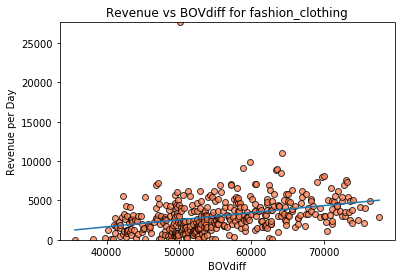

<class 'str'>
R2 = 0.22272101496883806


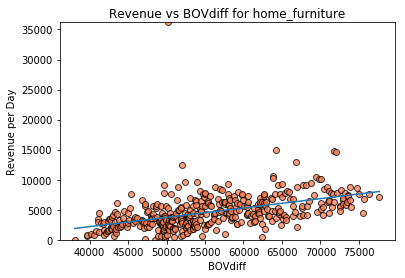

<class 'str'>
R2 = 0.12775736592701964


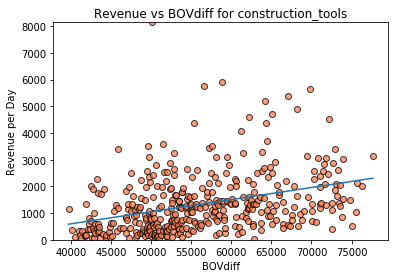

<class 'str'>
R2 = 0.21497465149845477


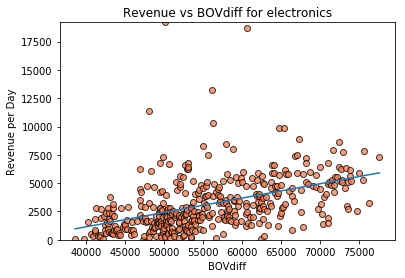

<class 'str'>
R2 = 0.0433044542244721


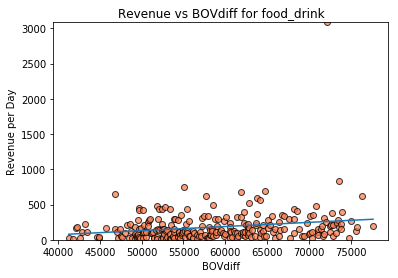

<class 'str'>
R2 = 0.015073830562731892


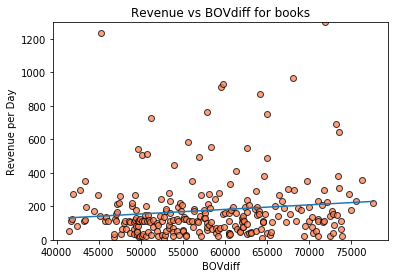

<class 'str'>
R2 = 0.04258542834116419


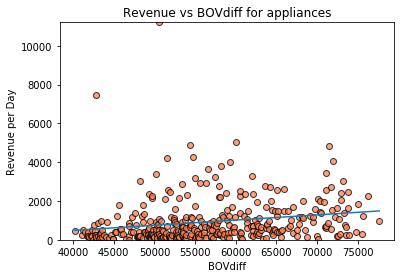

<class 'str'>
R2 = 0.15608622769057903


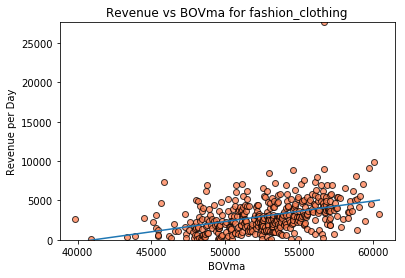

<class 'str'>
R2 = 0.16010208892321795


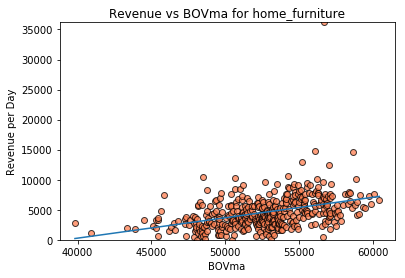

<class 'str'>
R2 = 0.1564630831028227


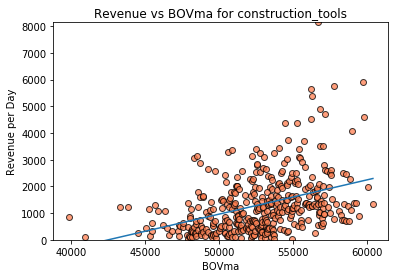

<class 'str'>
R2 = 0.061628877906144686


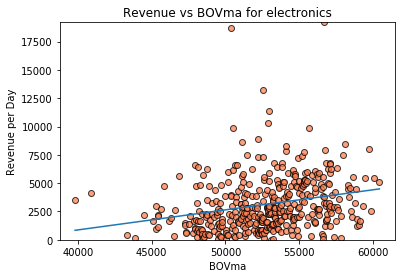

<class 'str'>
R2 = 0.02555972150860879


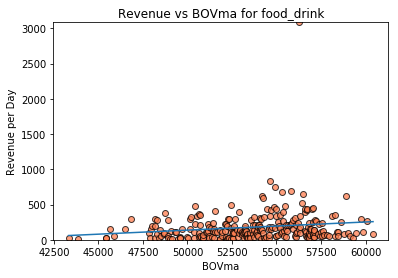

<class 'str'>
R2 = 0.022179361608012475


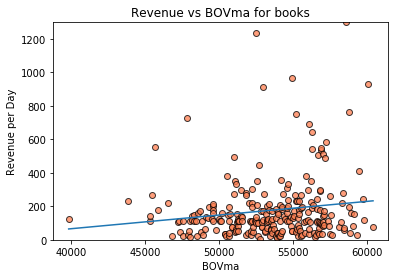

<class 'str'>
R2 = 0.042442108190637484


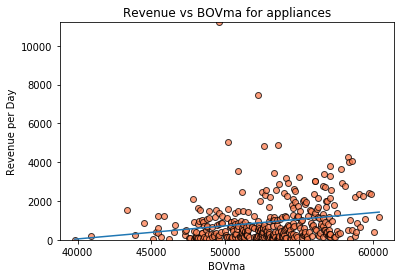

In [36]:
#BY CATEGORIES
for metric in metriclist:
    for cat in new_categories.keys():
        groupdf = mergedf.groupby([metric, 'category'])
        groupdf = groupdf.sum()
        #sum of prices
        #groupdf = groupdf.sum()
        groupdf.reset_index(inplace = True)
        #why are there sum of prices at 0? no data from those dates?
        groupdf = groupdf.loc[groupdf['price'] > 1]
        #change categories
        groupdf = groupdf.loc[groupdf['category'] == cat]

        plt.scatter(groupdf[metric], groupdf['price'], color=["coral"], edgecolor="black", alpha = 0.75,marker="o")
        plt.ylim(0, max(groupdf['price']))
        (slopeBOV, interceptBOV, rBOV, _, _) = linregress(groupdf[metric], groupdf['price'])
        fitBOV = slopeBOV * groupdf[metric] + interceptBOV
        plt.ylabel('Revenue per Day')
        plt.xlabel(metric)
        plt.title(f'Revenue vs {metric} for {cat}')
        print(type(metric))
        plt.plot(groupdf[metric], fitBOV)
        print(f'R2 = {rBOV**2}')
        plt.savefig('./Graphs/{metric}{cat}.png')
        plt.show()

BOV 0.394515472311203


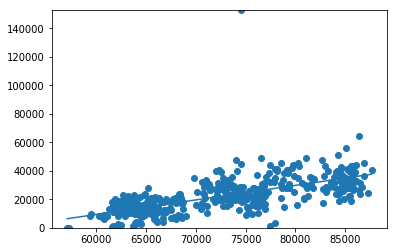

BOVdiff 0.30147414591437754


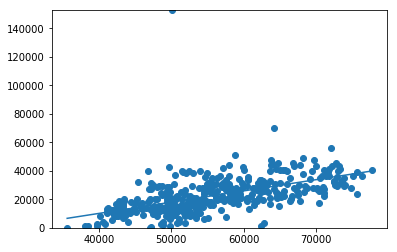

BOVma 0.21419024551505322


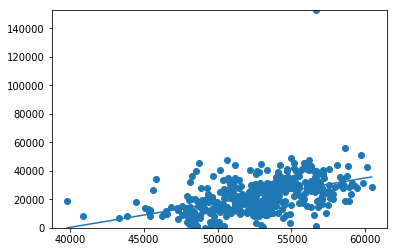

In [20]:
#ALL CATEGORIES
for metric in metriclist:
    groupdf = mergedf.groupby(metric)
    groupdf = groupdf.sum()
    groupdf.reset_index(inplace = True)
    #why are there sum of prices at 0? no data from those dates?
    groupdf = groupdf.loc[groupdf['price'] > 1]


    plt.scatter(groupdf[metric], groupdf['price'])
    plt.ylim(0, max(groupdf['price']))
    (slopeBOV, interceptBOV, rBOV, _, _) = linregress(groupdf[metric], groupdf['price'])

    fitBOV = slopeBOV * groupdf[metric] + interceptBOV
    print(metric, rBOV**2)
    plt.plot(groupdf[metric], fitBOV)
    plt.show()
    

In [21]:
#used to see what the outlier point was
#groupdf.sort_values('price', ascending= False).head()

In [22]:
plt.title?